In [17]:
import matplotlib.pyplot as plot

import numpy as np

import pickle

# Step 1: Parallel Implementation

Recall that prefix scan requires a barrier for synchronization In this step, you will write a work-efficient parallel prefix scan using pthread barriers. For each of the provided input sets, set the number of loops of the operator to 100000 (-l 100000) and graph the execution time of your parallel implementation over a sequential prefix scan implementation as a function of the number of worker threads used. Vary from 2 to 32 threads in increments of 2. Then, explain the trends in the graph. Why do these occur?

### Backstory
I started the journey by implementing a parallel n/p block reduce algorithm, that then reduces/scans each of the partial sums sequentially, and then scans the final sums back into each block - inspired by reading this - https://www.cs.cmu.edu/afs/cs/academic/class/15750-s11/www/handouts/PrefixSumBlelloch.pdf. I liked it because it was easy to implement and also see that it's work efficient - we do roughly `2*p*(n/p) + p` operations. Complexity is `O(n/p + p)`.

I then wanted to update the sequential part to be parallel - the theoretical asymptotic change is `log(p)` vs `p`. That meant implementing the parallel tree up-reduce, down-scan for the $p$-sized sum. Since it's a pea-sized array, I didn't expect it to practically be better for our values of $p$, since it also adds additional synchronization overhead. So let's look at the results.

Next, since I implemented the tree up-reduce/down-scan algorithm for the $p$ array, I figured I'd try the algorithm variant that uses that approach for
the whole input. The time complexity of the tree algorithm is $O(log(n))$ if it was parallelized at $p = n$, but with a fixed $p$ it is a $O(n/p + log(p))$.

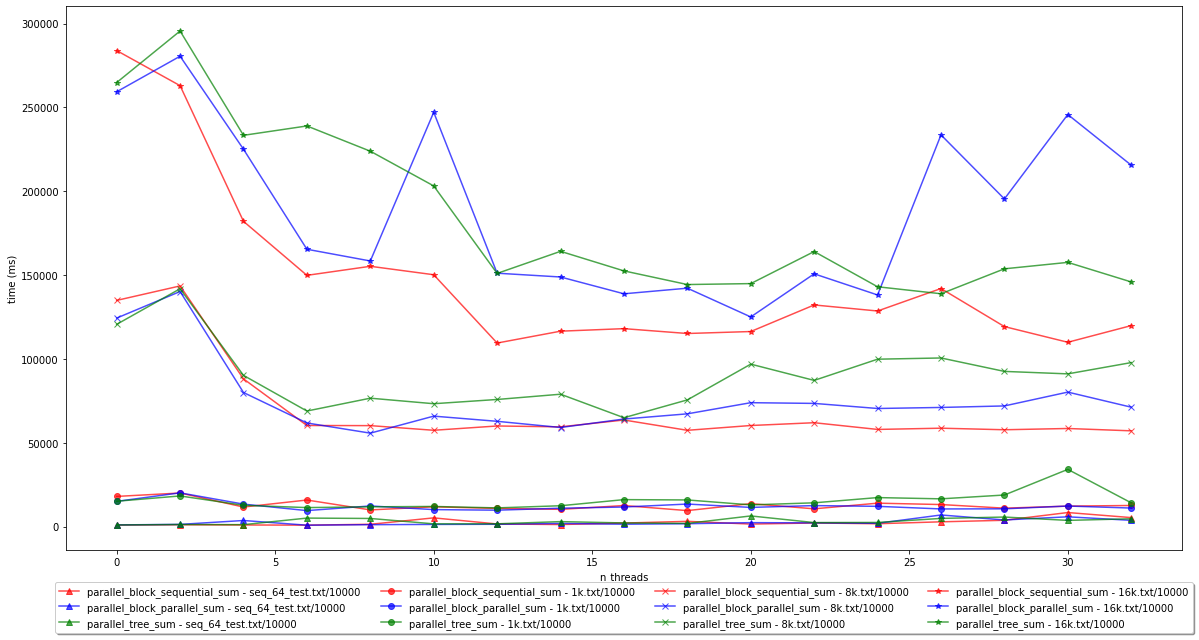

In [168]:
results = pickle.load(open("results/exp_1-10000.pickle", "rb"))

threads = [int(x) for x in results[0][2:]]

colors = {
    "parallel_block_sequential_sum": "r",
    "parallel_block_parallel_sum": "b",
    "parallel_tree_sum": "g",
}
markers = ["^", "o", "x", "*"]
    
plot.rcParams["figure.figsize"] = (20,10)

plot.xlabel("n_threads")
plot.ylabel("time (ms)")

m = 0
for result in results[1:]:
    line, = plot.plot(threads, [int(x) for x in result[2:]], marker=markers[int(m / 3)], color=colors[result[0]], alpha=0.7)
    line.set_label(result[0] + " - " + result[1])
    
    m += 1
    
plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=4)

plot.show()

## Round 1

Like expected, the algorithms performed comparatively. `parallel_block_sequential_sum` performed better overall in practice, but in theory, for a large number of processors $p = n$, both algorithms that use the tree approach would have an asymptotic $log(n)$, while the one that has a sequential would be an $O(n)$.

Next let's look at the speedup vs. sequential for `parallel_block_parallel_sum` since it's fully parallel.


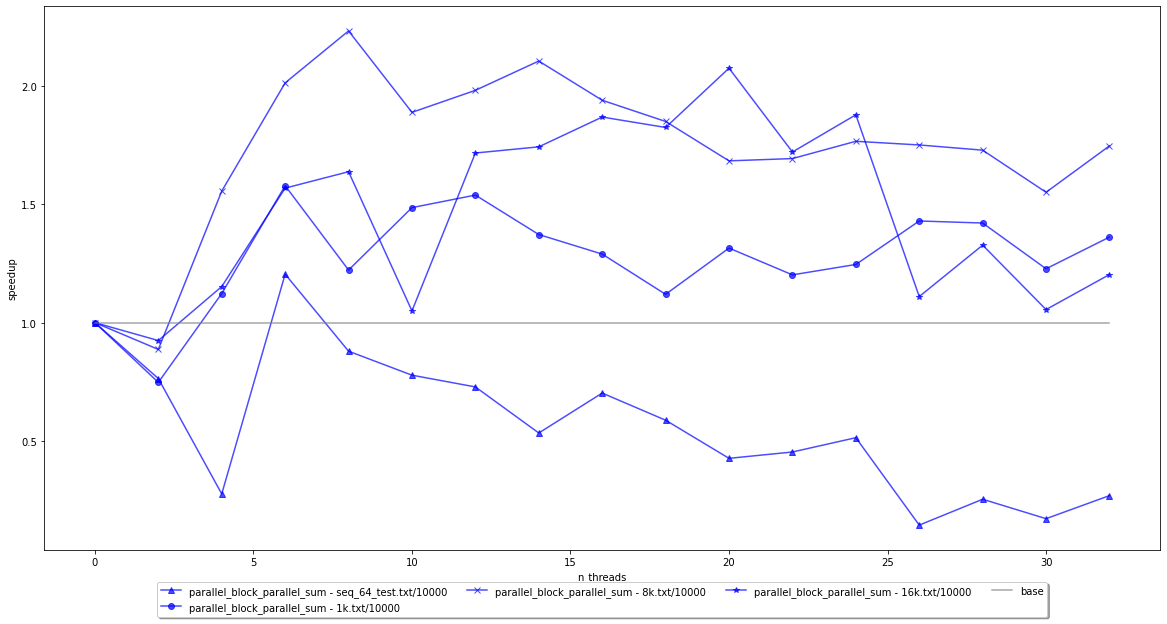

In [169]:
results = pickle.load(open("results/exp_1-10000.pickle", "rb"))

threads = [int(x) for x in results[0][2:]]

colors = {
    "parallel_block_sequential_sum": "r",
    "parallel_block_parallel_sum": "b",
    "parallel_tree_sum": "g",
}
markers = ["^", "o", "x", "*"]
    
plot.rcParams["figure.figsize"] = (20,10)

plot.xlabel("n_threads")
plot.ylabel("speedup")

m = 0
for result in results[1:]:
    if result[0] == "parallel_block_parallel_sum":
        line, = plot.plot(threads, [int(result[2])/int(x) for x in result[2:]], marker=markers[int(m / 3)], color=colors[result[0]], alpha=0.7)
        line.set_label(result[0] + " - " + result[1])
    
    m += 1
    
line, = plot.plot(threads, [1.0 for x in threads], color='gray', alpha=0.7)
line.set_label("base")

plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=4)

plot.show()

## Sequential vs parallel

From the graph above, we see that for a small input, the parallel algorithm performs at times worse the baseline. This is because the overhead of synchronizing the threads, plus the slight increase in number of operations makes the tradeoff not worth it. 

As we increase `n_threads` for the bigger data sets, the speedup increases steadily and levels off at the point where `n_threads == num_cpus` (in our case, 8 on codio). That's where we really are taking advantage of the parallelism; once `n_threads > num_cpus`, we can see the speedup leveling off, or, in the smaller test cases, decreasing as the overhead of threads is a bigger proportion of the work done. This is a CPU-bound process, so using more threads than CPUs does not give us any advantages.


# Step 2: Playing with Operators
Now that you have a working and, hopefully, efficient parallel implementation of prefix scan, try changing the amount of loops the operator does to 10 (-l 10) and plot the same graph as before. What happened and why? Vary the -l argument and find the inflexion point, where sequential and parallel elapsed times meet (does not have to be exact, just somewhat similar). Why can changing this number make the sequential version faster than the parallel? What is the most important characteristic of it that makes this happen? Argue this in a general way, as if different -l parameters were different operators, afterall, the -l parameter is just a way to quickly create an operator that does something different.

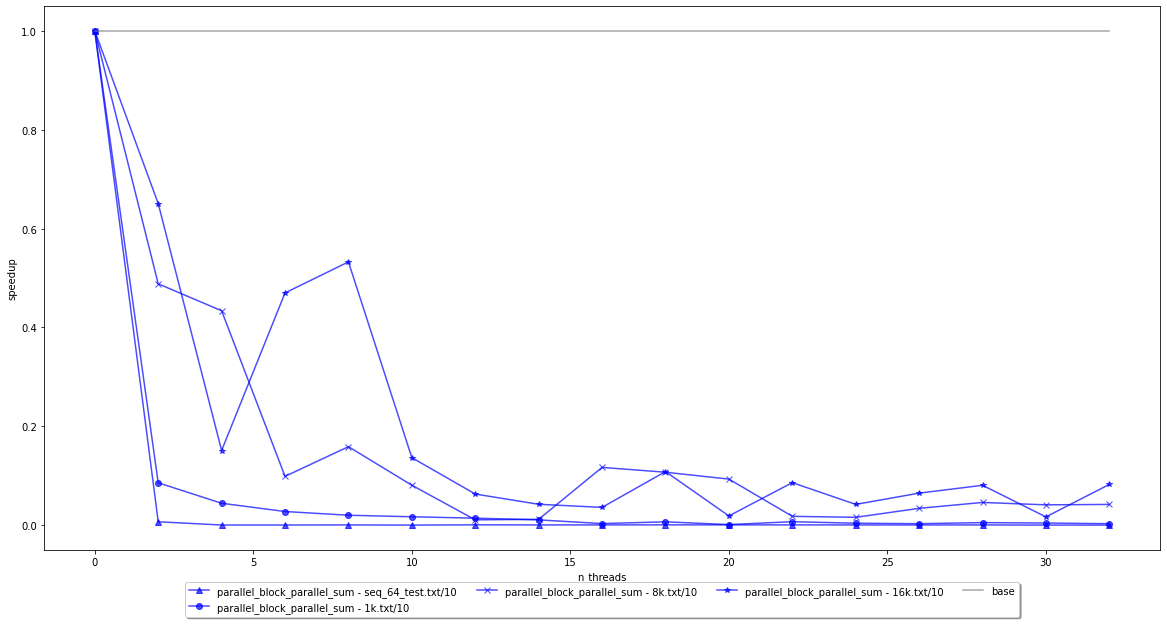

In [170]:
results = pickle.load(open("results/exp_1-10.pickle", "rb"))

threads = [int(x) for x in results[0][2:]]

colors = {
    "parallel_block_sequential_sum": "r",
    "parallel_block_parallel_sum": "b",
    "parallel_tree_sum": "g",
}
markers = ["^", "o", "x", "*"]
    
plot.rcParams["figure.figsize"] = (20,10)

plot.xlabel("n_threads")
plot.ylabel("speedup")

m = 0
for result in results[1:]:
    if result[0] == "parallel_block_parallel_sum":
        line, = plot.plot(threads, [int(result[2])/int(x) for x in result[2:]], marker=markers[int(m / 3)], color=colors[result[0]], alpha=0.7)
        line.set_label(result[0] + " - " + result[1])
    
    m += 1
    
line, = plot.plot(threads, [1.0 for x in threads], color='gray', alpha=0.7)
line.set_label("base")

plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=4)

plot.show()

### What happened?

The parallel algorithm performs much worse than the sequential. That is because with `-l 10` our operator is much less CPU-bound. That means the overhead of synchonization and also doing more operations in the parallel algorithm is now a bigger proportion of the timing profile of the program.

We can think of `-l` as a scalar that changes how much computation the operator does. Changing it can make the sequential variant faster because, at a smaller `l` the amount of CPU-bound time our program spends decreases (proportional to l), while the overhead of the parallel algorithm increases with the number of threads, which is represented by the downward slope of the speedup as `n_threads` increases. We can see that balance tipping for high values of `n_threads` at a low value of `-l`.

Another way to think of it is that a very CPU-bound operator (high `l`) will make the time-complexity of the algorithms more salient, since it will overshadow the rest of the program time, putting the sequential $O(n)$ in relief against the $O(n/p + log(p))$ of the parallel algorithm. The parallel algorithm shines when having to distribute heavy CPU-loads across CPUs; light loads get overshadowed by overhead.

The lines meet around the $100$ mark.

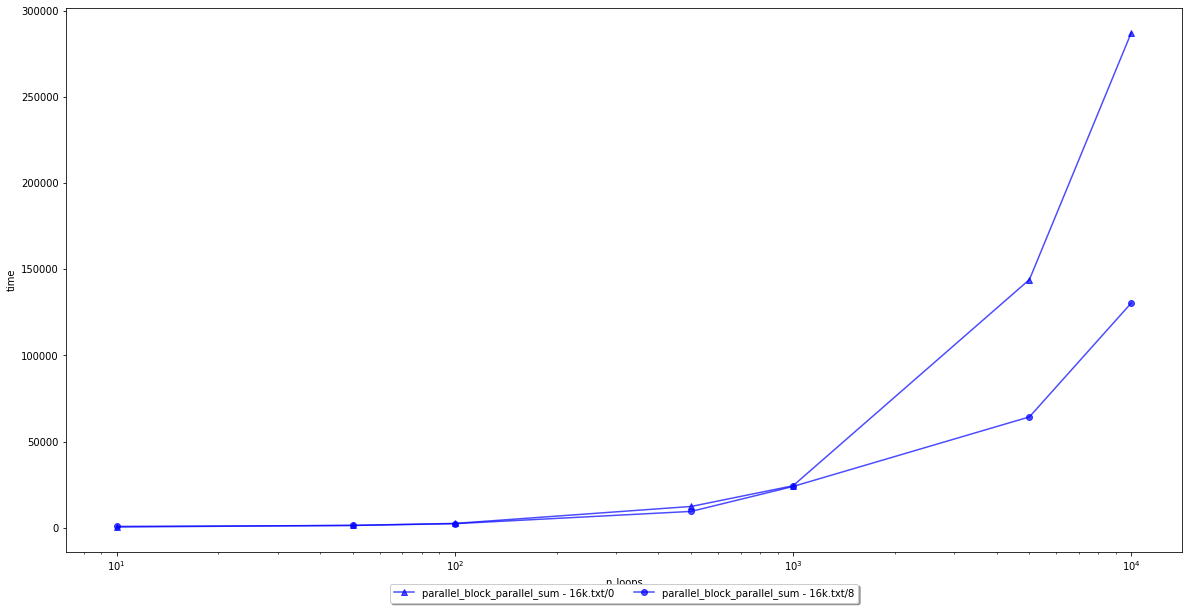

In [172]:
results = pickle.load(open("results/exp_2.pickle", "rb"))

loops = [int(x) for x in results[0][2:]]

colors = {
    "parallel_block_sequential_sum": "r",
    "parallel_block_parallel_sum": "b",
    "parallel_tree_sum": "g",
}
markers = ["^", "o", "x", "*"]
    
plot.rcParams["figure.figsize"] = (20,10)

plot.xlabel("n_loops")
plot.xscale("log")

plot.ylabel("time")

m = 0
for result in results[1:]:
    if result[0] == "parallel_block_parallel_sum":
        line, = plot.plot(loops, [int(x) for x in result[2:]], marker=markers[int(m % 2)], color=colors[result[0]], alpha=0.7)
        line.set_label(result[0] + " - " + result[1])
    m += 1
    
plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=4)

plot.show()

# Step 3: Barrier Implementation
In this step you will build your own re-entrant barrier. Recall from lecture that we considered a number of implementation strategies and techniques. We recommend you base your barrier on pthread's spinlocks, but encourage you to use other techniques we discussed in this course. Regardless of your technique, answer the following questions: how is/isn't your implementation different from pthread barriers? In what scenario(s) would each implementation perform better than the other? What are the pathological cases for each? Use your barrier implementation to implement the same work-efficient parallel prefix scan. Repeat the measurements from part 2, graph them, and explain the trends in the graph. Why do these occur? What overheads cause your implementation to underperform an "ideal" speedup ratio?

How do the results from part 2 and part 3 compare? Are they in line with your expectations? Suggest some workload scenarios which would make each implementation perform worse than the other.

### The Barrier

I chose the implement the very simple semaphore barrier from class using a spinlock as the synchonization object. The good news is that it worked. The bad news is that it's slower overall than the sequential.

My implementation is different than the [pthread barrier implementation](https://sourceware.org/git/?p=glibc.git;a=blob;f=nptl/pthread_barrier_wait.c;h=89936a08c7e9fbb51d4eeb24b7f1619a059e0b39;hb=HEAD) in a couple important ways. First of all, my implementation is simpler and easier to read, but pthreads is written by people who know what they're doing :)

Jokes aside, the implementations are pretty similar, except that
    1. pthread barrier uses one lock instead of two locks; the second lock they replace with a wait/signal mechanism, plus an atomic fetch_and_increment.
    2. my implementation uses spinlocks, pthreads uses futexes; spinlocks spin, futexes put threads to sleep
    
Overall the counter approach is similar, the decrement in both cases is protected by an acquired lock, but the increment happens through an atomic fetch_and_increment in the pthread case.

My implementation should theoretically perform better than the pthread barrier when the number of threads is less than the number of CPUs, and we can avoid incurring the penalty of making the thread sleep and switching context by spinning. This also assumes that the workloads of each of the threads is more or less the same. The pathological case for my algorithm is when the workloads are very uneven or there are more threads than CPUs; by spinning we are denying the other threads their CPU-time, or overall wasting CPU. Both can also have high-contention for the checked values, but especially the spinlock implementation.


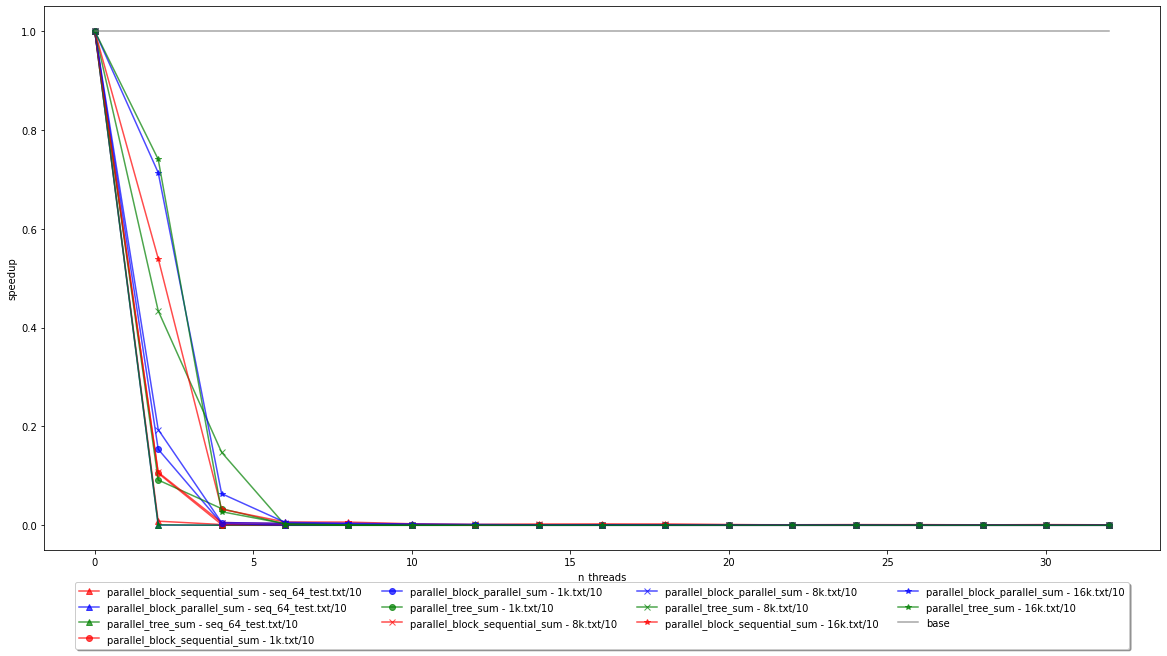

In [173]:
results = pickle.load(open("results/exp_1-10-s.pickle", "rb"))

threads = [int(x) for x in results[0][2:]]

colors = {
    "parallel_block_sequential_sum": "r",
    "parallel_block_parallel_sum": "b",
    "parallel_tree_sum": "g",
}
markers = ["^", "o", "x", "*"]
    
plot.rcParams["figure.figsize"] = (20,10)

plot.xlabel("n_threads")
plot.ylabel("speedup")

m = 0
for result in results[1:]:
    line, = plot.plot(threads, [int(result[2])/int(x) for x in result[2:]], marker=markers[int(m / 3)], color=colors[result[0]], alpha=0.7)
    line.set_label(result[0] + " - " + result[1])
    
    m += 1
    
line, = plot.plot(threads, [1.0 for x in threads], color='gray', alpha=0.7)
line.set_label("base")

plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=4)

plot.show()

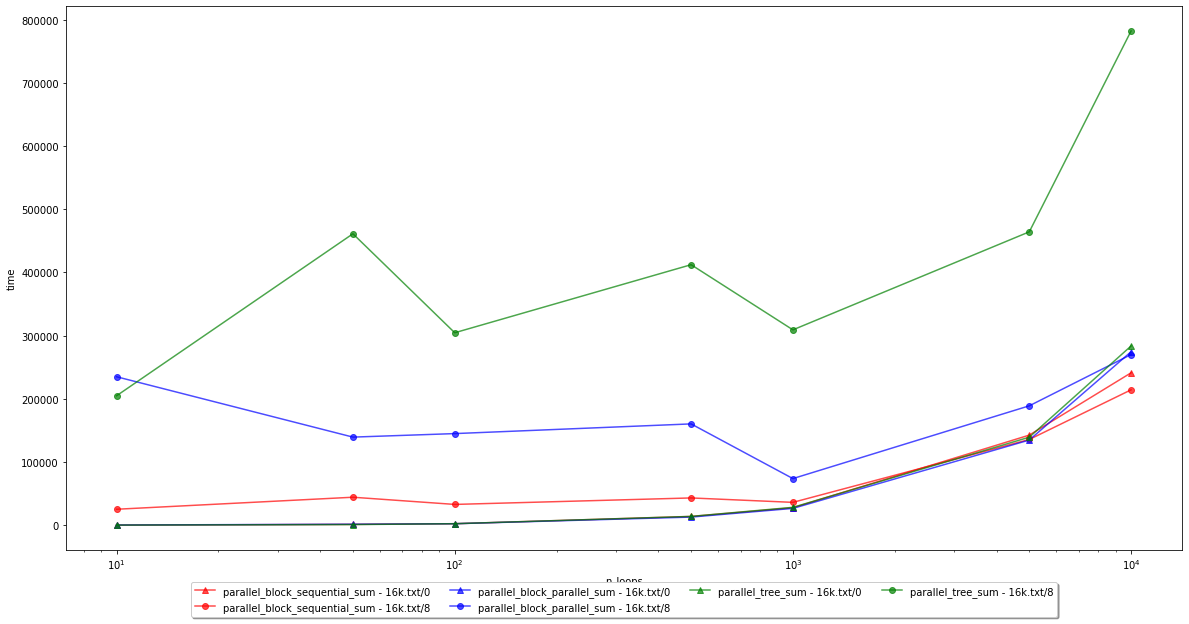

In [174]:
results = pickle.load(open("results/exp_2-s.pickle", "rb"))

loops = [int(x) for x in results[0][2:]]

colors = {
    "parallel_block_sequential_sum": "r",
    "parallel_block_parallel_sum": "b",
    "parallel_tree_sum": "g",
}
markers = ["^", "o", "x", "*"]
    
plot.rcParams["figure.figsize"] = (20,10)

plot.xlabel("n_loops")
plot.xscale("log")

plot.ylabel("time")

m = 0
for result in results[1:]:
    line, = plot.plot(loops, [int(x) for x in result[2:]], marker=markers[int(m % 2)], color=colors[result[0]], alpha=0.7)
    line.set_label(result[0] + " - " + result[1])
    m += 1
    
plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=4)

plot.show()

### Barrier Results

In the `n_thread`  graph you can see that (regardless of algorithm), the spinlock barrier implementation has speedup approaching 0 when `n_threads > n_cpu = 8`, which was aligned with what we expected. When `n_threads < n_cpu` we can see that, for some cases, the spinlock implementation is faster than the pthread (although more data would have to be gathered to show that conclusively), which is also expected.

In the `n_loops` graph you can see that the spinlock implementation performs worse than sequential, and ultimately provides a speedup higher than sequential for higher `-l`; this is because spinlocks will accentuate the overhead of 
synchronizing the threads as a proportion of program time, and also spinlocks will have higher contention on the shared memory locks. The overhead is clear between the different algorithms, since each uses a different number of synchronizations - $2log(n)$ for `tree`, $2 + 2log(p)$ for `parallel_block_parallel` and $2$ for `parallel_block_sequential`, and you can see those ratios represented in the graph. This only is made worse by the fact that, at each level of the tree, each thread will have a different workload, which accentuates the issue for higher values of `-l`, making the `tree` algorithm in the graph to be growing more for higher values of `l`.

A scenario where the pthread barriers would perform worse than the spinlock barrier would be an equal high-priority workload, `n_threads = n_cpus` with dedicated cpus and a high number of barriers, where context-switching costs would be a lot higher. A scenario where spinlock performs worse is... well right here :)